# Practical 1: IOT and National Accounts
In this exercise, you will practice how to apply the three methods to calculate national GDP, using different databases and years.  
While the exercise is quantitive, try to reason about differences and implications of the methods as well as results from the method application.

### Learning goals

- Analysing GDP trends
- Implementing GDP calculation methods in different contexts
- Understanding the data structure difference between SNA and IO tables 
- Understanding the implications of quantitative results

### Instructions

Data should be downloaded into a data/ folder in the same directory your module is, then it should be loaded and plotted in python

- Data source 1: eurostat, national accounts, main GDP aggregates https://ec.europa.eu/eurostat/web/national-accounts/database

- Data source 2: CBS https://www.cbs.nl/-/media/_excel/2022/27/83-inputoutput-tables-20152021.xlsx

Obtain, plot, and analyze the GDP time series for all years available

## Exercise 1
Using the EUROSTAT data plot a graph showing the yearly GDP change using the following approaches

- expenditure perspective (GDP = Consumption + Investment + Government Spending + Net Export)
- production perspective (GDP = Sum of all value added of all production activities)
- income perspective (GDP = Total National Income + Sales Taxes + Depreciation + Net Foreign Factor Income)

Make sure to use the metadata accompanying the data to help you understand all data available within the CSV file and the GDP elements https://ec.europa.eu/eurostat/cache/metadata/en/nama10_esms.htm

Tip: if you download csv.gz data this is CSV data that has been compressed. You can import it directly into python by using the "compression" argument in the method pd.read_csv()     

In [24]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('bmh')

# Import data

# replace None with the rest of the function to load the data 
GDP_data = pd.read_csv("nama_10_gdp_linear.csv.gz", compression="gzip")

# We are only interested in data in euros so make sure you slice the right currency
GDP_data = GDP_data[GDP_data.unit == "CP_MEUR"] 

# print the columns, it will help you understand how you can proceed in selecting the data
print(GDP_data.columns)

Index(['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'na_item', 'geo',
       'TIME_PERIOD', 'OBS_VALUE', 'OBS_FLAG'],
      dtype='object')


**Print all unique values in the National Account Item column (na_item) to use as a reference**

You can investigate what each code means by checking the vocabulary on the European Environment Agency website 

https://dd.eionet.europa.eu/vocabulary/eurostat/na_item/view

or you can check the statistical terms glossary for full definitions

https://data.un.org/Glossary.aspx

In [25]:
print(GDP_data.na_item.unique())

['B11' 'B111' 'B112' 'B1G' 'B1GQ' 'B2A3G' 'D1' 'D11' 'D12' 'D2' 'D21'
 'D21X31' 'D2X3' 'D3' 'D31' 'P3' 'P31_S13' 'P31_S14' 'P31_S14_S15'
 'P31_S15' 'P32_S13' 'P3_P5' 'P3_P6' 'P3_S13' 'P41' 'P51G' 'P52' 'P52_P53'
 'P53' 'P5G' 'P6' 'P61' 'P62' 'P7' 'P71' 'P72' 'YA0' 'YA1' 'YA2']


#### Create a dictionary in which you will store your GDP results for comparison

In [26]:
NA_GDP_approaches_results = {"income": None, "expenditure": None, "production": None}

#### Income approach

Isolate all data for the income approach:
- comp_employees = "D1"
- Gross operating surplus and mixed income = "B2A3G" 
    - gross_operating_surplus = "B2G"
    - mixed_income = "B3G"
- taxes less subsidies on production and imports (D2X3)
    - taxes_less_subsidies = "D2"
    - imports = "D3"


In [27]:
# select national account codes to be isolated in the data 
breakdown_income = ["D1", "B2A3G", "D2X3"]

# Check wether all the items are available in the GDP breakdown csv
for bi in breakdown_income:
    if bi not in GDP_data.na_item.unique():
        print(bi)

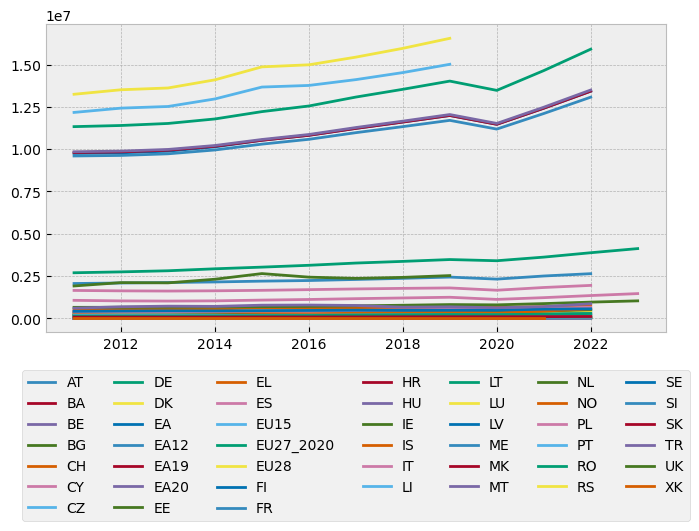

In [28]:
# organize and plot your results for the income approach

GDP_breakdown = GDP_data[GDP_data.na_item.isin(breakdown_income)]
plt.figure(figsize=(8,4))

country_GDP_series = {}
for country in GDP_breakdown.geo.unique(): 
    country_data = GDP_breakdown[GDP_breakdown.geo==country]
    country_data = country_data[country_data.TIME_PERIOD >= 2011]
    yearly_GDP = {}
    for year in country_data.TIME_PERIOD.unique():
        year_data = country_data[country_data.TIME_PERIOD==year]
        yearly_GDP[year] = year_data.OBS_VALUE.sum()
                
    plt.plot(yearly_GDP.keys(), yearly_GDP.values(), label=country)
    country_GDP_series[country] = yearly_GDP

NA_GDP_approaches_results["income"] = country_GDP_series
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=7)
plt.show()

# for entry in country_GDP_series["NL"]:
#     print("NL",entry, country_GDP_series["NL"][entry])

#### Expenditure approach
Isolate all data for the expenditure approach:
- final_consumption = "P3"
- gross_fixed_capital_form = "P51"
- changes_in_inventories = "P52"
- acquisition_less_disposal_of_val = "P53"
- exports = "P6"
- imports = "P7"

In [29]:
# select national account codes to be isolated in the data 
breakdown_expen = ["P3", "P51G", "P52", "P53", "P6", "P7"]

# Check wether all the items are available in the GDP breakdown csv
for bi in breakdown_expen:
    if bi not in GDP_data.na_item.unique():
        print(bi)

In [30]:
# organize and plot your results for the expenditure approach

GDP_breakdown = GDP_data[GDP_data.na_item.isin(breakdown_expen)]

country_GDP_series = {}
for country in GDP_breakdown.geo.unique(): 
    country_data = GDP_breakdown[GDP_breakdown.geo==country]

    country_data = country_data[country_data.TIME_PERIOD >= 2011]
    
    yearly_GDP = {}
    
    for year in country_data.TIME_PERIOD.unique():
        year_data = country_data[country_data.TIME_PERIOD==year]
    
        all_minus_impo = year_data[year_data.na_item != "P7"].OBS_VALUE.sum()
    
        imports = year_data[year_data.na_item == "P7"].OBS_VALUE.item()

        yearly_GDP[year] = all_minus_impo - imports
        
    country_GDP_series[country] = yearly_GDP

NA_GDP_approaches_results["expenditure"] = country_GDP_series

# for entry in country_GDP_series["NL"]:
#     print("NL",entry, country_GDP_series["NL"][entry])

#### Production approach

Isolate all data for the production approach:
- total_gross_value_added = "B1G"
- taxes_on_products = "D21"
- subsidies = "D31"


In [31]:
# select national account codes to be isolated in the data 
breakdown_prod = ["B1G", "D21", "D31"]

# Check wether all the items are available in the GDP breakdown csv
for bi in breakdown_prod:
    if bi not in GDP_data.na_item.unique():
        print(bi)

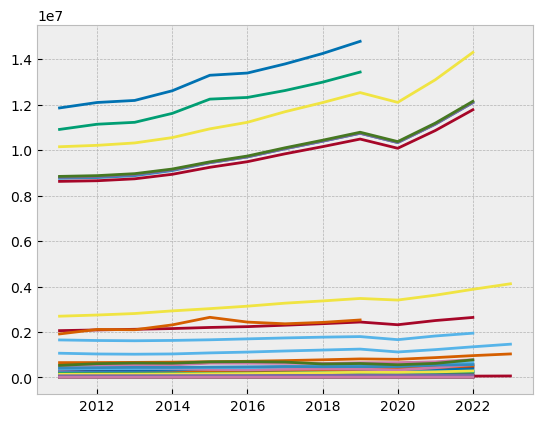

In [32]:
# organize and plot your results for the production approach

GDP_breakdown = GDP_data[GDP_data.na_item.isin(breakdown_prod)]

country_GDP_series = {}

for country in GDP_breakdown.geo.unique(): 
    country_data = GDP_breakdown[GDP_breakdown.geo==country]
    country_data = country_data[country_data.TIME_PERIOD >= 2011]
    yearly_GDP = {}

    for year in country_data.TIME_PERIOD.unique():
        year_data = country_data[country_data.TIME_PERIOD==year]
        yearly_GDP[year] = year_data[year_data.na_item != "D31"].OBS_VALUE.sum() - year_data[year_data.na_item == "D31"].OBS_VALUE.sum()

    plt.plot(yearly_GDP.keys(), yearly_GDP.values(), label=country)
    country_GDP_series[country] = yearly_GDP

NA_GDP_approaches_results["production"] = country_GDP_series

# for entry in country_GDP_series["NL"]:
#     print("NL",entry, country_GDP_series["NL"][entry])
    

#### Check your results
You don't have to check every single entry, just select one country for each approach, "NL" is fine too 

In [22]:
country = "NL"

income_approach = pd.Series(NA_GDP_approaches_results["income"][country])
expenditure_approach = pd.Series(NA_GDP_approaches_results["expenditure"][country])
production_approach = pd.Series(NA_GDP_approaches_results["production"][country])

check_comparison = pd.concat([income_approach, expenditure_approach, production_approach], axis=1)
check_comparison.columns = NA_GDP_approaches_results.keys()

print(check_comparison)

         income  expenditure  production
2011   650359.0     650359.0    650359.0
2012   652966.0     652966.0    652966.0
2013   660463.0     660463.0    660463.0
2014   671560.0     671560.0    671560.0
2015   690008.0     690008.0    690008.0
2016   708337.0     708337.0    708337.0
2017   738146.0     738146.0    738146.0
2018   773987.0     773987.0    773987.0
2019   813055.0     813055.0    813055.0
2020   796530.0     796530.0    796530.0
2021   870587.0     870587.0    870587.0
2022   958549.0     958549.0    958549.0
2023  1032841.0    1032841.0   1032841.0


## Exercise 2

Using the CBS data calculate the total GDP total and its composition using the three approaches

Methods can be found using the following link in the file "2 Macroeconomic totals.xlsx" 

https://www.cbs.nl/en-gb/custom/2022/27/national-accounts-2021-tables

Tip: once you download the data have a good look at how it is structure, how the labels are organized.

In order to better understand how GDP can be calculated in IOTs, use the EUROSTAT manual table 11.6 on page 305


![image](./figures/IOT_basic_price.PNG)

In [14]:
# Load the IO data
CBS_IO = pd.ExcelFile(f"data/CBS/83 InputOutput tables 20152021.xlsx", engine="openpyxl")

# Print the list of sheets that are available in the xlsx file so that you can investigate what options you have
print(*CBS_IO.sheet_names, sep="\n")

IO-table 2015 current prices
IO-table 2016 current prices
IO-table 2016 PY prices
IO-table 2017 current prices
IO-table 2017 PY prices
IO-table 2018 current prices
IO-table 2018 PY prices
IO-table 2019 current prices
IO-table 2019 PY prices
IO-table 2020 current prices
IO-table 2020 PY prices
IO-table 2021 current prices
IO-table 2021 PY prices
Explanation


#### Parse your data

In [15]:
# Parse the sheet for 2021 in current prices
IO_2021_cp = CBS_IO.parse("IO-table 2021 current prices", index_col=1, header=1, skipfooter=3)

IO_2021_cp = IO_2021_cp.iloc[1:, 1:].fillna(0)

# Labels sometimes have leading and trailing white spaces which makes it difficult to then slice the dataframe
IO_2021_cp.columns = IO_2021_cp.columns.str.strip()
IO_2021_cp.index = IO_2021_cp.index.str.strip()
# There could also be errors in labels, always check. It won't matter for this exercise but keep in mind for the future. 
# Examples of mistakes are typos, wrong translaction, encoding issues 

# Negative items
# Makes sure that the items marked with a negative sign in their labels are indeed negative
items_with_neg = ["Subsidies on domestic products (–)","Import subsidies (–)","Other subsidies on production (–)"]
IO_2021_cp.loc[(items_with_neg)] = IO_2021_cp.loc[items_with_neg] *-1

# Print the columns and index to understand how the data is structured

# for ind in IO_2021_cp.index:
#     print("index: ", ind)
    
# for col in IO_2021_cp.columns:
#     print("column: ", col)

#### Perfom some checks
Before we begin working with the data, we typically want to perform some data sanity checks. 
We will only perform one check in this exercise, keeping in mind, however, that in most cases one needs to perform quite thorough cleaning (e.g., check for NaNs, decimal separators). 


Check that the total inputs are equal to the total outputs

In [16]:
total_inputs = IO_2021_cp.loc["Total",:"Goods and services n.e.c."].sum()
total_outputs = IO_2021_cp.loc[:"Goods and services n.e.c.","Total"].sum()

print(f"Inputs and Outputs match: {total_inputs/total_outputs*100}%")

Inputs and Outputs match: 100.0%


#### Create a dictionary in which you will store your results to be later compared

In [17]:
IO_GDP_approaches_results = {"income": None, "expenditure": None}

In [20]:
# Income perspective

income_items = ["Wages and salaries", 
                "Employers' social contributions", 
                "Operating surplus (gross)", 
                "Import duties", 
                "Taxes on domestic products",
                "Import subsidies (–)",
                "Other taxes on imports", 
                "Other taxes on production", 
                "Subsidies on domestic products (–)",
                "Other subsidies on production (–)"
                ]

income_breakdown = IO_2021_cp.loc[income_items]

# We need to drop the total so that we don't double count
income_breakdown = income_breakdown.drop(["Total (1–81)","Total"] ,axis=1)

IO_GDP_approaches_results["income"] = income_breakdown.values.sum()

IO_GDP_approaches_results["income"]

856356.0

In [58]:
# Expenditure perspective

expenditure_items = ["Exports of goods",
                     "Exports of services",
                     "Final consumption expenditure of households",
                     "Final consumption expenditure of NPIs serving households",
                     "Social transfers in kind",
                     "Other individual final consumption of general goevernment",
                     "Collective final consumption of general gorvernment",
                     "Gross fixed capital formation",
                     "Changes in inventories 1)",
                     "Trade and transport margins",
                     "Cif/fob-adjustment and reclassification",
                     "Cif/fob-reclassification"                     
                     ]

imports_items =['Imports of goods',
                'Imports of services']

expenditure_breakdown = IO_2021_cp.loc[:, expenditure_items]
# we eliminate the rows with aggregates and totals
expenditure_breakdown = expenditure_breakdown.drop(["Total of rows (1–81)", "Total intermediate consumption (82–90)", "Total", "Value added at basic prices (92–96)"], axis=0)

# We sum all imports to be substracted
imports_Z = IO_2021_cp.loc[imports_items, :"Goods and services n.e.c."].values.sum()
imports_Y = IO_2021_cp.loc[imports_items, expenditure_items].values.sum()
tot_imports = imports_Z + imports_Y

IO_GDP_approaches_results["expenditure"] = expenditure_breakdown.values.sum() - tot_imports
IO_GDP_approaches_results["expenditure"]


856356.0

In [57]:
# Calculate the production perspective use the Value added row
# we use the value added row provided by the table as a reference to see whether our calculations are correct
value_added = IO_2021_cp.loc["Value added at basic prices (92–96)" , :"Goods and services n.e.c."]
VA_total = value_added.values.sum() + taxes_less_subsidies.values.sum()

for l in IO_GDP_approaches_results:
    print(f"{l} approach results: {IO_GDP_approaches_results[l]} results are off by {round((1-VA_total/IO_GDP_approaches_results[l])*100)}%")


production approach results: 856356.0 results are off by 0%
income approach results: 856356.0 results are off by 0%
expenditure approach results: 856356.0 results are off by 0%
